In [1]:
import numpy as np
import json
import os
import pandas as pd
from matplotlib import pyplot as plt
import sys
from scipy import stats

In [12]:
# subjects to analyze
subjects = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
PATH_BASE = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\ECoG_STN\\"

In [59]:
def set_box_color(bp, color):
    #plt.setp(bp['boxes'], color='black')
    #plt.setp(bp['whiskers'], color='black')
    #plt.setp(bp['caps'], color='black')
    plt.setp(bp['medians'], color='black')
    l_ = []
    l_.append(color)
    l_ = l_*len(bp['boxes']) 
    for patch, color_ in zip(bp['boxes'], l_):
        patch.set_facecolor(color_)
    
def my_box_plot_comparison_here(data_a, data_b, label_1='contralateral', label_2='ipsilateral'):
    ran = len(data_a)
    ticks = [str(i) for i in range(ran)]
    bpl = plt.boxplot(data_a, positions=np.array(range(ran))*2.0-0.4, showmeans=True, widths=0.45, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(ran))*2.0+0.4, showmeans=True,widths=0.45, patch_artist=True)
    set_box_color(bpl, 'red') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label=label_1)
    plt.plot([], c='blue', label=label_2)

    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    #plt.xticks(range(0, len(ticks) * 2, 2), ['LM', 'NN', 'SPOC t-lag', 'XGB '+r'$\beta$'+ r'$\gamma$', 'XGB'], rotation=90)
    plt.xticks(range(0, len(ticks) * 2, 2), ['LM', 'SPOC', 'XGB'], rotation=90)
    plt.ylabel(r'$R^2$')
    plt.ylim(-0.1, 0.8)
    plt.legend(loc='upper left')
    

In [52]:
def get_res(PATH_, all_=True, best_Tr=False, SPOC_ = False, log_=False):
    """
    Given the resp. Path for LM/XGB/NN based on single channel estimaton; 
    return rather all, oder just the best CV test or test(best train) performances 
    returns dict(ECOG CON, ECOG IPS; STN CON, STN IPS)
    """
    res_files = os.listdir(PATH_)
    res_ = {}; # ECOG CON, ECOG IPS; STN CON, STN IPS
    for loc in ["ECOG", "STN"]:
        for lat in ["CON", "IPS"]:
            patients_ = []
            for sub in subjects:
                files = [f for f in res_files if (sub in f) and (loc in f)]
                max_ = []; tr_ = []; te_ = []
                for file in files: # Sess right or left
                    
                    if log_ is True: print(file)
                    if all_ is True:
                        max_.append(np.load(os.path.join(PATH_, file), 
                                               allow_pickle=True).tolist()["score_te"][lat])
                    else:
                        if SPOC_ is False:
                            max_.append(np.max(np.load(os.path.join(PATH_, file), 
                                               allow_pickle=True).tolist()["score_te"][lat]))
                            tr_.append(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_tr"][lat])
                            te_.append(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_te"][lat])

                        else:
                            max_.append(np.mean(np.load(os.path.join(PATH_, file), 
                                               allow_pickle=True).tolist()["score_te"][lat]))
                            tr_.append(np.mean(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_tr"][lat]))
                            te_.append(np.mean(np.load(os.path.join(PATH_, file), allow_pickle=True).tolist()["score_te"][lat]))

                if all_ is True: 
                    patients_.append(np.concatenate(max_).ravel())
                else:
                    if best_Tr is True:
                        if SPOC_ is False:
                            patients_.append(np.concatenate(te_).ravel()[np.argmax(np.concatenate(tr_).ravel())])
                        else:
                            patients_.append(np.ravel(te_)[np.argmax(np.ravel(tr_))])
                    else:
                        patients_.append(np.max(max_))
            res_[loc+"_"+lat] = np.concatenate(patients_).ravel() if all_ is True else patients_
    return res_

In [60]:
res_XGB =  get_res(os.path.join(PATH_BASE, "XGB_Out"), all_=True, best_Tr=True, log_=False, SPOC_=False)
res_LM =  get_res(os.path.join(PATH_BASE, "LM_Out"), all_=True, best_Tr=True, log_=False, SPOC_=False)
res_SPOC = get_res(os.path.join(PATH_BASE, "SPOC_predictions"), all_=True, best_Tr=False, log_=False, SPOC_=True)

C:\Users\ICN_admin\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator ElasticNet from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


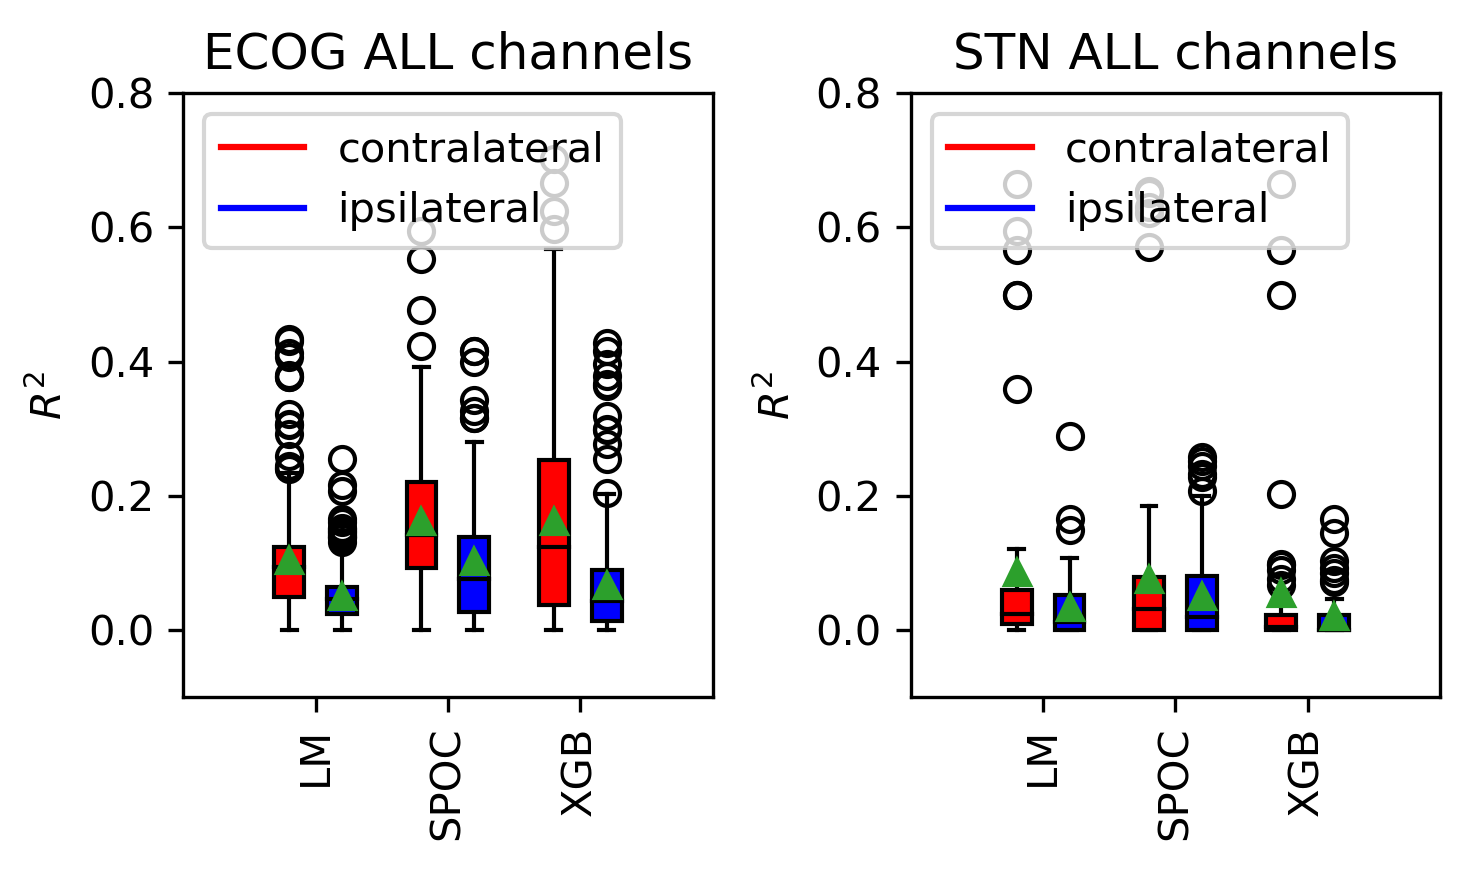

In [61]:
plt.figure(figsize=(5,3), dpi=300)
plt.subplot(121)
plt.title('ECOG ALL channels')
my_box_plot_comparison_here([res_LM["ECOG_CON"], res_SPOC["ECOG_CON"], res_XGB["ECOG_CON"]], \
                            [res_LM["ECOG_IPS"], res_SPOC["ECOG_IPS"], res_XGB["ECOG_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')

plt.subplot(122)
plt.title('STN ALL channels')
my_box_plot_comparison_here([res_LM["STN_CON"], res_SPOC["STN_CON"], res_XGB["STN_CON"]], \
                            [res_LM["STN_IPS"], res_SPOC["STN_IPS"], res_XGB["STN_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')
plt.ylabel(r'$R^2$')
plt.tight_layout()

C:\Users\ICN_admin\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator ElasticNet from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


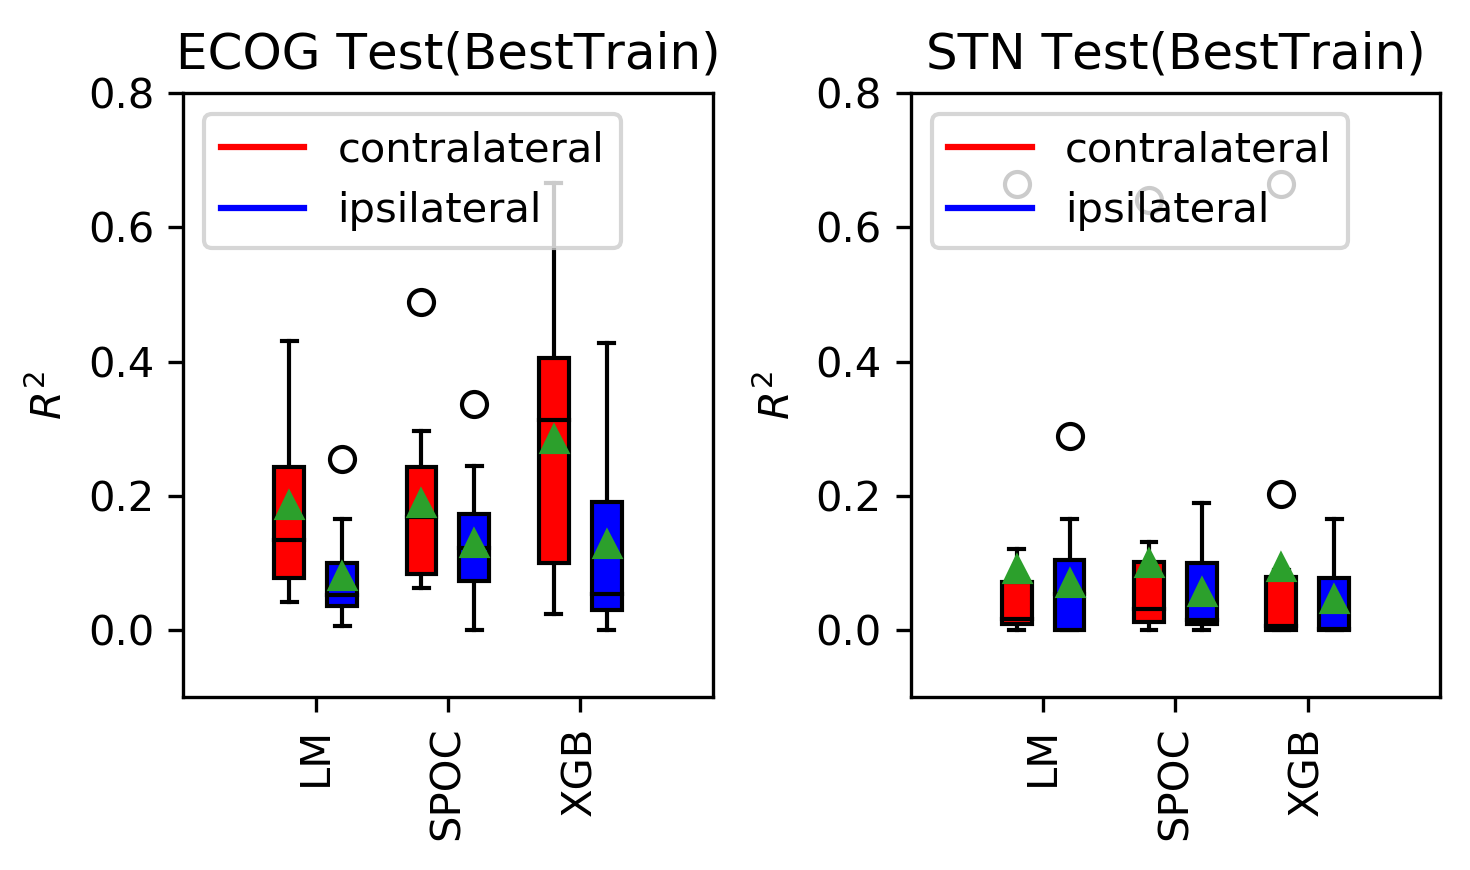

In [62]:
res_XGB =  get_res(os.path.join(PATH_BASE, "XGB_Out"), all_=False, best_Tr=True, log_=False, SPOC_=False)
res_LM =  get_res(os.path.join(PATH_BASE, "LM_Out"), all_=False, best_Tr=True, log_=False, SPOC_=False)
res_SPOC = get_res(os.path.join(PATH_BASE, "SPOC_predictions"), all_=False, best_Tr=True, log_=False, SPOC_=True)
plt.figure(figsize=(5,3), dpi=300)
plt.subplot(121)
plt.title('ECOG Test(BestTrain)')
my_box_plot_comparison_here([res_LM["ECOG_CON"], res_SPOC["ECOG_CON"], res_XGB["ECOG_CON"]], \
                            [res_LM["ECOG_IPS"], res_SPOC["ECOG_IPS"], res_XGB["ECOG_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')

plt.subplot(122)
plt.title('STN Test(BestTrain)')
my_box_plot_comparison_here([res_LM["STN_CON"], res_SPOC["STN_CON"], res_XGB["STN_CON"]], \
                            [res_LM["STN_IPS"], res_SPOC["STN_IPS"], res_XGB["STN_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')
plt.ylabel(r'$R^2$')
plt.tight_layout()

C:\Users\ICN_admin\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator ElasticNet from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


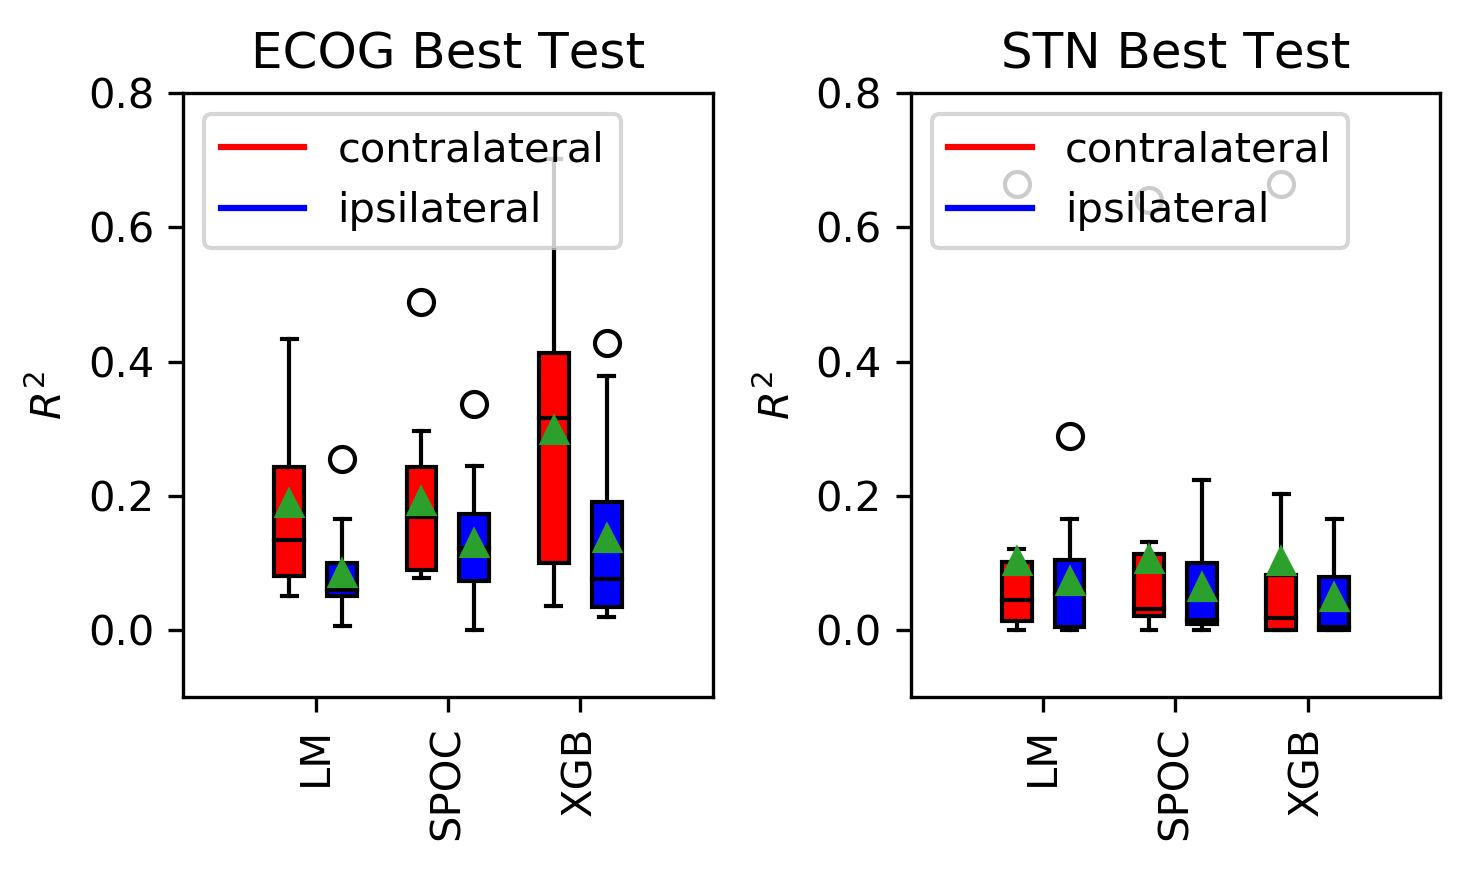

In [63]:
res_XGB =  get_res(os.path.join(PATH_BASE, "XGB_Out"), all_=False, best_Tr=False, log_=False, SPOC_=False)
res_LM =  get_res(os.path.join(PATH_BASE, "LM_Out"), all_=False, best_Tr=False, log_=False, SPOC_=False)
res_SPOC = get_res(os.path.join(PATH_BASE, "SPOC_predictions"), all_=False, best_Tr=False, log_=False, SPOC_=True)
plt.figure(figsize=(5,3), dpi=300)
plt.subplot(121)
plt.title('ECOG Best Test')
my_box_plot_comparison_here([res_LM["ECOG_CON"], res_SPOC["ECOG_CON"], res_XGB["ECOG_CON"]], \
                            [res_LM["ECOG_IPS"], res_SPOC["ECOG_IPS"], res_XGB["ECOG_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')

plt.subplot(122)
plt.title('STN Best Test')
my_box_plot_comparison_here([res_LM["STN_CON"], res_SPOC["STN_CON"], res_XGB["STN_CON"]], \
                            [res_LM["STN_IPS"], res_SPOC["STN_IPS"], res_XGB["STN_IPS"]], \
                            label_1='contralateral', label_2='ipsilateral')
plt.ylabel(r'$R^2$')
plt.tight_layout()